# 이모티콘 인식 V1 Dataset 점검 & 업로드

JSONL + 이미지를 로드하여 DataFrame으로 확인하고,
Qwen3-VL fine-tuning 형식으로 변환 후 HuggingFace에 업로드합니다.

### dataset.jsonl 스키마
| 필드 | 설명 |
|---|---|
| `episode_id` | 세션 ID |
| `round` | 라운드 번호 |
| `system_prompt` | 시스템 프롬프트 |
| `context_text` | 컨텍스트 텍스트 |
| `image_file` | 스크린샷 상대 경로 |
| `tool_calls` | `[{name, args}]` |
| `tool_results` | `[{name, result}]` |
| `thought_text` | Gemini 사고 과정 |
| `answer_text` | 정답 텍스트 |
| `visible_animals` | 정답 동물 목록 |
| `is_correct` | 정답 여부 |

In [1]:
import json
import pandas as pd
from pathlib import Path
from IPython.display import display
from dotenv import load_dotenv

load_dotenv()
DATA_DIR = Path("../data/emoji-recognition")
DATASET_FILE = DATA_DIR / "dataset.jsonl"

# Load JSONL
rows = []
with open(DATASET_FILE, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line:
            rows.append(json.loads(line))

print(f"Loaded {len(rows)} rounds from {DATASET_FILE}")
print(f"Sessions: {len(set(r['episode_id'] for r in rows))}")
print(f"Fields: {list(rows[0].keys()) if rows else '(empty)'}")

Loaded 500 rounds from ..\data\emoji-recognition\dataset.jsonl
Sessions: 2
Fields: ['episode_id', 'round', 'system_prompt', 'context_text', 'image_file', 'tool_calls', 'tool_results', 'thought_text', 'answer_text', 'visible_animals', 'is_correct']


In [2]:
# DataFrame으로 전체 데이터 확인
df = pd.DataFrame([
    {
        "episode_id": r["episode_id"],
        "round": r["round"],
        "image_file": r["image_file"],
        "image_exists": (DATA_DIR / r["image_file"]).exists(),
        "is_correct": r["is_correct"],
        "n_animals": len(r.get("visible_animals", [])),
        "has_thought": r.get("thought_text") is not None,
    }
    for r in rows
])

print(f"Shape: {df.shape}")
print(f"정답률: {df['is_correct'].mean()*100:.1f}%")
print(f"이미지 존재: {df['image_exists'].sum()}/{len(df)}")
display(df.head(20))

Shape: (500, 7)
정답률: 97.2%
이미지 존재: 500/500


,episode_id,round,image_file,image_exists,is_correct,n_animals,has_thought
0,emoji-rec-ec8a9f3e,2,images/emoji_rec_ec8a9f3e_round_002.png,True,True,4,True
1,emoji-rec-ec8a9f3e,3,images/emoji_rec_ec8a9f3e_round_003.png,True,True,3,False
2,emoji-rec-ec8a9f3e,4,images/emoji_rec_ec8a9f3e_round_004.png,True,True,4,False
3,emoji-rec-ec8a9f3e,5,images/emoji_rec_ec8a9f3e_round_005.png,True,True,2,False
4,emoji-rec-ec8a9f3e,6,images/emoji_rec_ec8a9f3e_round_006.png,True,True,3,False
5,emoji-rec-ec8a9f3e,7,images/emoji_rec_ec8a9f3e_round_007.png,True,True,3,False
6,emoji-rec-ec8a9f3e,8,images/emoji_rec_ec8a9f3e_round_008.png,True,False,3,False
7,emoji-rec-ec8a9f3e,9,images/emoji_rec_ec8a9f3e_round_009.png,True,True,3,False
8,emoji-rec-ec8a9f3e,10,images/emoji_rec_ec8a9f3e_round_010.png,True,True,4,False
9,emoji-rec-ec8a9f3e,11,images/emoji_rec_ec8a9f3e_round_011.png,True,True,3,False


In [3]:
# 64조합 커버리지 확인
from collections import Counter

combo_counter = Counter()
for r in rows:
    for a in r.get("visible_animals", []):
        combo_counter[(a["emoji"], a["bgColor"])] += 1

print(f"총 조합 수: {len(combo_counter)}/64")
print(f"총 동물 출현 수: {sum(combo_counter.values())}")

# 미출현 조합
ANIMAL_EMOJIS = ['🐯', '🐘', '🦒', '🐒', '🦓', '🦁', '🐷', '🐨']
BG_COLORS = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF', '#FFA500', '#800080']
missing = [(e, c) for e in ANIMAL_EMOJIS for c in BG_COLORS if (e, c) not in combo_counter]
if missing:
    print(f"\n미출현 조합 ({len(missing)}개):")
    for e, c in missing[:10]:
        print(f"  {e} + {c}")
else:
    print("\n✅ 모든 64조합 커버됨!")

총 조합 수: 64/64
총 동물 출현 수: 1459

✅ 모든 64조합 커버됨!


Episode: emoji-rec-ec8a9f3e
Round: 2
Correct: True

--- 정답 ---
(0,7) 주황색 코끼리(🐘)
(4,2) 초록색 코끼리(🐘)
(6,1) 노란색 원숭이(🐒)
(3,3) 노란색 돼지(🐷)

--- LLM 응답 ---
[관찰]
- (6,1) 노란색 원숭이(🐒)
- (4,2) 초록색 코끼리(🐘)
- (3,3) 노란색 돼지(🐷)
- (0,7) 주황색 코끼리(🐘)

--- Thought ---
**Animal Identification in a Grid**

Alright, let's break this down systematically. I need to identify all the animals within a 10x10 grid image. First, I need to establish a clear coordinate system. (x, y) coordinates, with x representing the column (0-9) and y the row (0-9). The top-left corner is (0,0) and the bottom-right is (9,9).

Now, let's scan the grid row by row. Row 0 and Row 8 and 9 are empty.

*   **Row 1:** I see a tree (🌲) at (2,1). There is a yellow background and a monkey (🐒) at


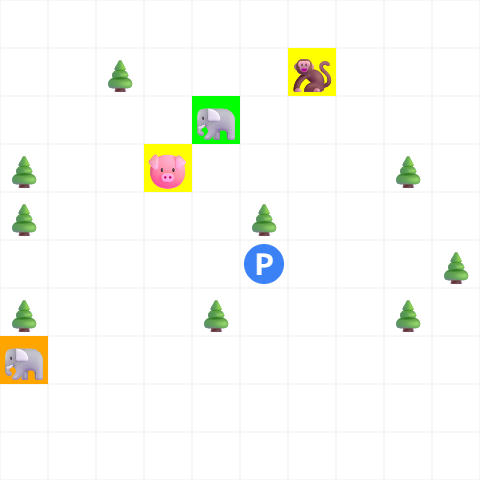

In [4]:
# 첫 번째 엔트리 상세 확인
if rows:
    r = rows[0]
    print(f"Episode: {r['episode_id']}")
    print(f"Round: {r['round']}")
    print(f"Correct: {r['is_correct']}")
    print(f"\n--- 정답 ---")
    print(r["answer_text"])
    print(f"\n--- LLM 응답 ---")
    for tc in r.get("tool_calls", []):
        print(tc["args"].get("content", ""))
    print(f"\n--- Thought ---")
    print(r.get("thought_text", "(없음)")[:500])

    # 이미지 미리보기
    from PIL import Image as PILImage
    img_path = DATA_DIR / r["image_file"]
    if img_path.exists():
        display(PILImage.open(img_path))

## Qwen3-VL Fine-Tuning 포맷 변환

각 라운드를 Qwen3-VL 학습 데이터로 변환합니다.

```
1라운드 = system + user(image+text) + assistant(thought + tool_call) + tool(result)
```

In [5]:
# Qwen3-VL tool definition
QWEN3_TOOLS = [
    {
        "type": "function",
        "function": {
            "name": "update_notepad",
            "description": "관찰 결과를 메모장에 기록합니다. 발견한 모든 동물의 위치, 색상, 종류를 기록하세요.",
            "parameters": {
                "type": "object",
                "properties": {"content": {"type": "string", "description": "관찰 내용"}},
                "required": ["content"]
            }
        }
    }
]


def convert_to_qwen3(entry):
    """단일 라운드를 Qwen3-VL fine-tuning 포맷으로 변환"""
    thought = entry.get("thought_text")

    messages = [
        {"role": "system", "content": entry["system_prompt"]},
        {
            "role": "user",
            "content": [
                {"type": "image", "image": f"data/emoji-recognition/{entry['image_file']}"},
                {"type": "text", "text": entry["context_text"]},
            ]
        },
    ]

    # Assistant (thought + tool_calls)
    # 정답 기반으로 tool_call content 생성 (LLM 응답 대신 정답 사용)
    answer_content = entry.get("answer_text", "")
    notepad_text = f"[관찰]\n{answer_content}"

    assistant_msg = {
        "role": "assistant",
        "content": thought,
        "tool_calls": [
            {
                "type": "function",
                "function": {
                    "name": "update_notepad",
                    "arguments": json.dumps({"content": notepad_text}, ensure_ascii=False),
                }
            }
        ],
    }
    messages.append(assistant_msg)

    # Tool result
    messages.append({
        "role": "tool",
        "name": "update_notepad",
        "content": json.dumps({"status": "updated"}, ensure_ascii=False),
    })

    return {"messages": messages, "tools": QWEN3_TOOLS}


# 변환 실행 (정답 라벨은 항상 프로그래밍적으로 생성되므로 전체 데이터 사용)
qwen3_examples = [convert_to_qwen3(r) for r in rows]
print(f"Converted {len(qwen3_examples)} rounds to Qwen3-VL format (total: {len(rows)})")

# 검증
for i, ex in enumerate(qwen3_examples[:5]):
    msgs = ex["messages"]
    roles = [m["role"] for m in msgs]
    has_thought = msgs[2]["content"] is not None if len(msgs) > 2 else False
    n_tool_calls = len(msgs[2].get("tool_calls", [])) if len(msgs) > 2 else 0
    n_tool_results = sum(1 for m in msgs if m["role"] == "tool")
    print(f"  [{i}] roles={roles} | thought={'✅' if has_thought else '❌'} | tc={n_tool_calls} | tr={n_tool_results}")

Converted 500 rounds to Qwen3-VL format (total: 500)
  [0] roles=['system', 'user', 'assistant', 'tool'] | thought=✅ | tc=1 | tr=1
  [1] roles=['system', 'user', 'assistant', 'tool'] | thought=❌ | tc=1 | tr=1
  [2] roles=['system', 'user', 'assistant', 'tool'] | thought=❌ | tc=1 | tr=1
  [3] roles=['system', 'user', 'assistant', 'tool'] | thought=❌ | tc=1 | tr=1
  [4] roles=['system', 'user', 'assistant', 'tool'] | thought=❌ | tc=1 | tr=1


In [6]:
# dataset-qwen3.jsonl 저장
QWEN3_FILE = DATA_DIR / "dataset-qwen3.jsonl"

with open(QWEN3_FILE, "w", encoding="utf-8") as f:
    for ex in qwen3_examples:
        f.write(json.dumps(ex, ensure_ascii=False) + "\n")

file_size_mb = QWEN3_FILE.stat().st_size / (1024 * 1024)
print(f"Saved {len(qwen3_examples)} examples to {QWEN3_FILE}")
print(f"File size: {file_size_mb:.2f} MB")

Saved 500 examples to ..\data\emoji-recognition\dataset-qwen3.jsonl
File size: 1.25 MB


## HuggingFace 업로드

In [7]:
from datasets import Dataset, Image as HFImage
from huggingface_hub import login

records = []
for r in rows:
    img_path = DATA_DIR / r["image_file"]
    records.append({
        "episode_id": r["episode_id"],
        "round": r["round"],
        "system_prompt": r["system_prompt"],
        "context_text": r["context_text"],
        "image": str(img_path) if img_path.exists() else None,
        "tool_calls": json.dumps(r.get("tool_calls", []), ensure_ascii=False),
        "tool_results": json.dumps(r.get("tool_results", []), ensure_ascii=False),
        "thought_text": r.get("thought_text", ""),
        "answer_text": r.get("answer_text", ""),
        "visible_animals": json.dumps(r.get("visible_animals", []), ensure_ascii=False),
        "is_correct": r["is_correct"],
    })

ds = Dataset.from_list(records)
ds = ds.cast_column("image", HFImage())
print(ds)
print("\nSample:")
print(ds[0])

Dataset({
    features: ['episode_id', 'round', 'system_prompt', 'context_text', 'image', 'tool_calls', 'tool_results', 'thought_text', 'answer_text', 'visible_animals', 'is_correct'],
    num_rows: 500
})

Sample:
{'episode_id': 'emoji-rec-ec8a9f3e', 'round': 2, 'system_prompt': '당신은 이모티콘 인식 전문가입니다.\n10x10 뷰포트 이미지를 보고, 보이는 모든 동물을 식별해야 합니다.\n\n## 뷰포트 설명\n- 10x10 격자 (좌표 0~9)\n- 각 타일은 48x48 픽셀\n- 동물: 이모지 + 색상 배경 (예: 빨간 배경 위 🐯)\n- 나무: 🌲 (배경 없음)\n- 플레이어: 파란 원 안 "P"\n\n## 식별 대상 동물\n🐯 호랑이, 🐘 코끼리, 🦒 기린, 🐒 원숭이, 🦓 얼룩말, 🦁 사자, 🐷 돼지, 🐨 코알라\n\n## 식별 대상 배경색\n빨간색(#FF0000), 초록색(#00FF00), 파란색(#0000FF), 노란색(#FFFF00),\n자주색(#FF00FF), 청록색(#00FFFF), 주황색(#FFA500), 보라색(#800080)\n\n## 응답 형식\nupdate_notepad 도구를 사용하여 관찰 결과를 기록하세요.\n\n[관찰]\n- (x좌표,y좌표) 색상이름 동물이름(이모지)\n예시:\n- (3,7) 빨간색 호랑이(🐯)\n- (8,2) 노란색 원숭이(🐒)\n\n정확한 좌표, 색상, 동물 종류를 모두 식별해야 합니다.', 'context_text': '이 이미지에서 보이는 동물을 모두 식별해주세요.\n각 동물의 위치(x,y), 배경색, 동물 종류를 정확히 기록해주세요.', 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=480x480 at 0x21A971

In [8]:
from datasets import load_dataset, concatenate_datasets

REPO_ID = "adwel94/vision-emoji-recognition-v1"
login()

# 기존 데이터셋 다운로드 (없으면 스킵)
try:
    remote_ds = load_dataset(REPO_ID, split="train")
    print(f"Remote: {len(remote_ds)} rows")
except Exception:
    remote_ds = None
    print("Remote dataset not found, uploading fresh")

print(f"Local: {len(ds)} rows")

# 머지 (episode_id + round 기준 중복 제거)
if remote_ds is not None:
    local_keys = {(r["episode_id"], r["round"]) for r in ds}
    remote_new = remote_ds.filter(
        lambda r: (r["episode_id"], r["round"]) not in local_keys
    )
    if len(remote_new) > 0:
        merged_ds = concatenate_datasets([ds, remote_new])
        print(f"Merged: {len(merged_ds)} rows ({len(remote_new)} from remote)")
    else:
        merged_ds = ds
        print("No new data from remote")
else:
    merged_ds = ds

# 업로드
merged_ds.push_to_hub(REPO_ID, private=False)
print(f"Uploaded {len(merged_ds)} rows to {REPO_ID}")

README.md:   0%|          | 0.00/670 [00:00<?, ?B/s]

C:\Users\hun41\miniconda3\envs\playground\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\hun41\.cache\huggingface\hub\datasets--adwel94--vision-emoji-recognition-v1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


data/train-00000-of-00001.parquet:   0%|          | 0.00/8.98M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/300 [00:00<?, ? examples/s]

Remote: 300 rows
Local: 500 rows


Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

No new data from remote


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :  58%|#####7    | 8.67MB / 15.0MB            

Uploaded 500 rows to adwel94/vision-emoji-recognition-v1
